#1. Import de Bibliotecas:

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import heapq
from time import time

In [7]:
!apt-get install megatools
!megadl 'https://mega.nz/folder/1U43jIqR#-hIdN7PGN6tH2QrBkF6TtQ'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
ERROR: File already exists at /content/Caminhao/Input1.txt
ERROR: File already exists at /content/Caminhao/Input2.txt
ERROR: File already exists at /content/Caminhao/Input4.txt
ERROR: File already exists at /content/Caminhao/Input3.txt
ERROR: File already exists at /content/Caminhao/casosTesteCaminhao.zip


#2. Desenvolvimento do Trabalho:


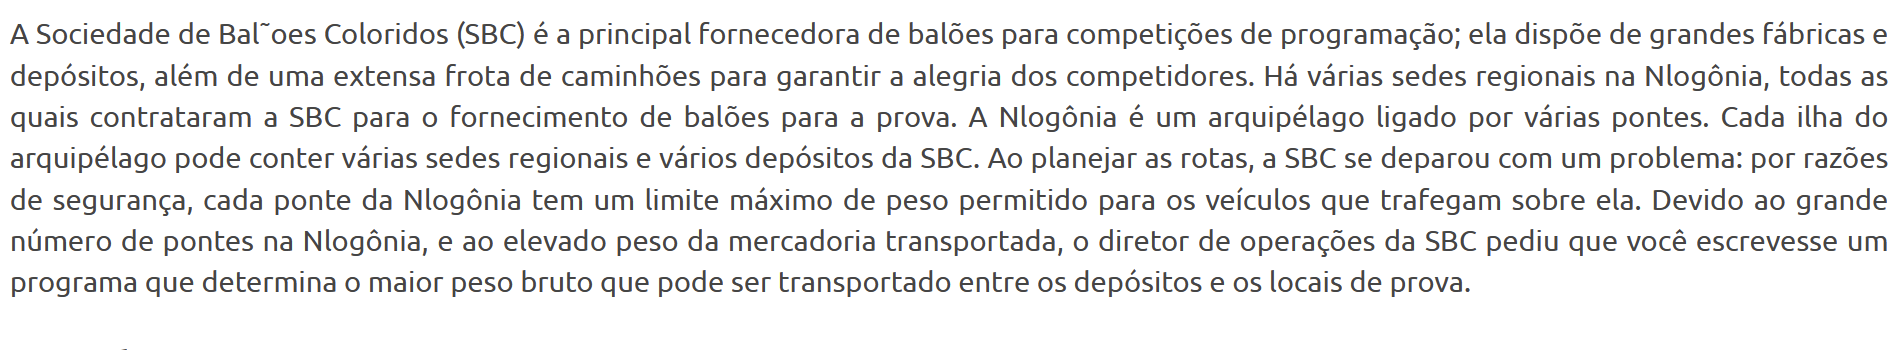


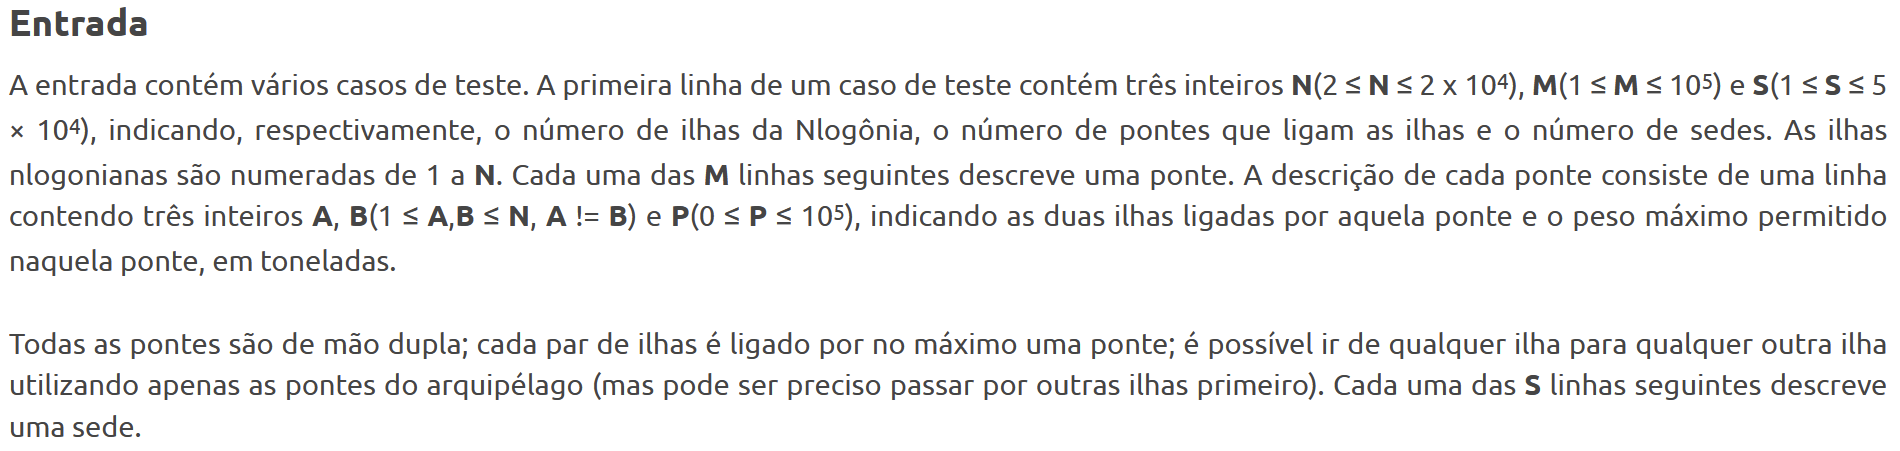

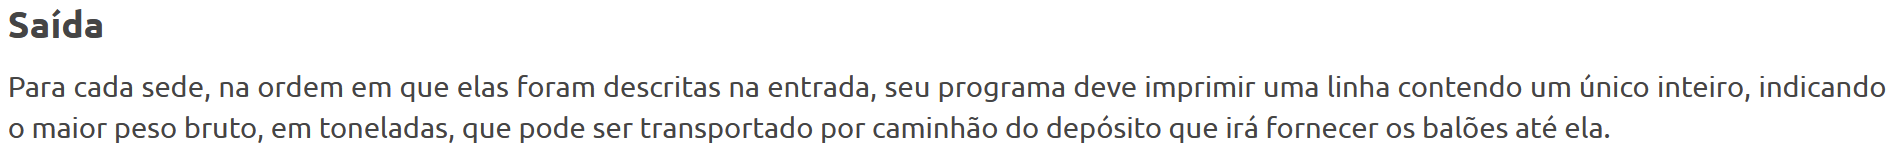

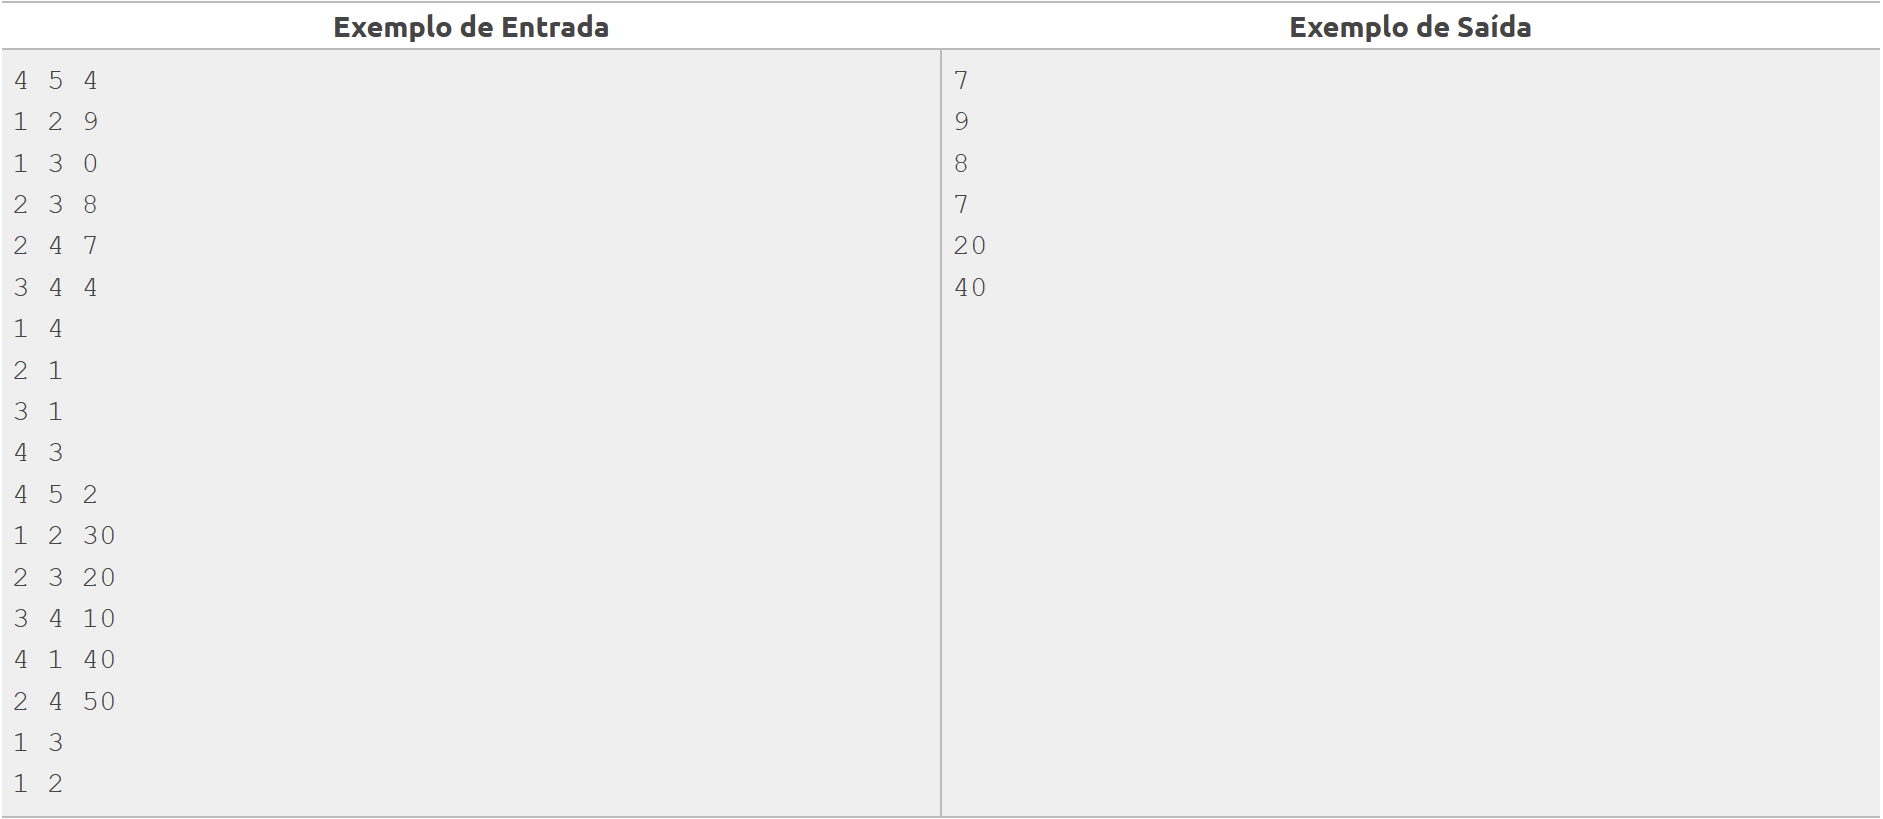

Primeira Linha: <p>
1º: Nº de Ilhas <p>
2º: Nº de Pontes <p>
3º: Sedes

Linha Ponte: <p>
1º: Origem <p>
2º: Destino <p>
3º: Peso máximo

Linha Sedes: <p>
1º: Início do Trajeto <p>
2º: Fim do Trajeto

##Import de matriz convencional

In [8]:
with zipfile.ZipFile("/content/Caminhao/casosTesteCaminhao.zip", 'r') as zip_ref:
  zip_ref.extractall("arquivos_teste")

In [101]:
arquivo = "/content/Caminhao/Input4.txt"

matriz = []
# Ler o arquivo linha por linha
with open(arquivo, "r") as file:
  for linha in file:
    # Ignorar linhas vazias
    if not linha.strip():
      continue
    # Converter a linha em uma lista de inteiros
    numeros = [int(x) for x in linha.strip().split()]
    if len(numeros) not in (2, 3):  # Verificar se a linha tem 2 ou 3 números
      raise ValueError(f"Linha inválida: {linha.strip()} - Esperado 2 ou 3 números")
    matriz.append(numeros)

print(f"Tamanho da matriz: {len(matriz)} linhas")
print(f"Primeiras 5 linhas: {matriz[:5]}")

Tamanho da matriz: 21 linhas
Primeiras 5 linhas: [[10, 15, 5], [1, 2, 10], [2, 3, 20], [3, 4, 30], [4, 5, 40]]


##2.1. Algoritmo de Djikstra

Inicialmente, buscamos utilizar ferramentas prontas do próprio networkX para a execução do trabalho, bem como entender o funcionamento do algoritmo e como utilizá-lo para a realização do exercício. <p>
Escolhemos o algoritmo de Djikstra pois ele tem um objetivo semelhante, na qual apenas mudar o funcionamento dos pesos talvez funcionaria. <p>
Mas com testes, vimos que ele obteve falhas de funcionamento para salvar os caminhos, e como estávamos utilizando uma função pronta, decidimos procurar algoritmos de Djikstra abertos e modificá-los para o nosso objetivo de maximizar o menor peso possível (O Djikstra busca Minimizar a soma).

In [102]:
def djikstra(grafo, inicio, fim):
  # Transformar pesos para maximizar o peso mínimo (Dijkstra minimiza soma)
  max_peso = float('-inf')
  for _, _, dados in grafo.edges(data=True):
    peso = dados['weight']
    if peso > max_peso:
      max_peso = peso
  max_peso += 1
  grafo_transformado = nx.Graph()
  for a, b, c in grafo.edges(data=True):
      grafo_transformado.add_edge(a, b, weight=max_peso - c['weight'])

  # Verificar se existe caminho entre inicio e fim
  if not nx.has_path(grafo_transformado, inicio, fim):
    return [], float('-inf')

  # Encontrar o caminho usando dijkstra_path
  caminho = nx.dijkstra_path(grafo_transformado, inicio, fim, weight='weight')
  # Calcular o peso mínimo no grafo original
  peso_minimo = float('inf')
  for i in range(len(caminho) - 1):
    peso = grafo[caminho[i]][caminho[i+1]]['weight']
    if peso < peso_minimo:
      peso_minimo = peso

  return caminho, peso_minimo

##2.2. Djikstra Modificado (Caminho de maior peso mínimo)

Reunimos a base das informações do funcionamento do Djikstra e modificamos para se adequar ao nosso objetivo: <p>
  - Inicializar os pesos com valor infinito, porém diferente do nó inicial
  - Utilizar o nó de maior peso
  - Fazer uma lista dos caminhos visitados para evitar passar mais de uma vez
  - Iterar sobre os vizinhos e montar um caminho, mas desta vez, buscando o menor peso possível dentro do caminho de maior peso. <p>

Além disso, utilizando a fila de prioridades e a iteração, o custo aproximado é de (𝑂(𝑉² + 𝐸)), que é um custo razoável, porem não é o ideal quando comparado ao algoritmo original do Djikstra (Custo O((V + E)logV)).

In [103]:
def dijkstra_modificado(grafo, inicio, fim):
  # Inicializar os pesos máximos e os caminhos
  pesos = {}
  for no in grafo.nodes:
    pesos[no] = float('-inf')
  pesos[inicio] = float('inf')  # Peso inicial é o maior

  caminho = {}
  for no in grafo.nodes:
    caminho[no] = []
  caminho[inicio] = [inicio]


  # Fila de prioridade
  visitados = set()
  nos = set(grafo.nodes)

  def peso(no):
    return pesos[no]

  while nos:
    # Escolher o nó com maior peso acumulado
    no_atual = max((no for no in nos if no not in visitados),
      key = peso, default = None)
    if no_atual is None:
      break

    visitados.add(no_atual)
    nos.remove(no_atual)

    # Para cada vizinho do nó atual
    for vizinho in grafo.neighbors(no_atual):
      if vizinho in visitados:
        continue

      # Peso da aresta
      peso_aresta = grafo[no_atual][vizinho]['weight']
      # Peso do caminho até o vizinho é o mínimo entre o peso acumulado e o peso da aresta
      peso_caminho = min(pesos[no_atual], peso_aresta)

      if peso_caminho > pesos[vizinho]:
        pesos[vizinho] = peso_caminho
        caminho[vizinho] = caminho[no_atual] + [vizinho]

  return caminho[fim], pesos[fim]


Com o código funcionando, buscamos entender quais melhorias seriam possíveis, e: <p>
  - Poderíamos utilizar outros algoritmos que usam a Maximum Spanning Tree, porém são menos diretos para encontrar apenas um caminho.
  - Existe também o algoritmo Floyd-Marshal, porém tem muito custo computacional, O(V³)
  - A melhoria ideal então seria diminuir o custo computacional buscando outras maneiras de armazenar e manipular as informações, como um Max-heap (Custo O((V + E)logV), igual ao Djikstra original) ou um Fibonacci-heap (Custo O(E + V . logV))

##2.3 Kruskal

Pensando em custo computacional, resolvemos utilizar as ferramentas do networkx para desenvolver uma função que utilize o algoritmo de Kruskal através de uma Maximum Spanning Tree pois o caminho entre quaisquer dois nós tem a garantia de maximizar o peso mínimo da aresta, pois a MST prioriza os maiores pesos ao formar a árvore. <p>
Além disso, o algoritmo tem a complexidade de O(E logV), que é menor comparada aos demais.

In [104]:
def kruskal(grafo, inicio, fim):
  # Calcula a Maximum Spanning Tree diretamente com maximum_spanning_tree
  maxsptree = nx.maximum_spanning_tree(grafo, weight='weight', algorithm='kruskal')

  # Verificar se existe caminho na MST
  if not nx.has_path(maxsptree, inicio, fim):
    return [], float('-inf')

  # Encontrar o caminho na MST (será o caminho com maior peso mínimo)
  caminho = nx.shortest_path(maxsptree, inicio, fim, weight=None)

  # Pega o peso mínimo do caminho salvo
  peso_minimo = float('inf')
  for i in range(len(caminho) - 1):
    peso = grafo[caminho[i]][caminho[i+1]]['weight']
    if peso < peso_minimo:
      peso_minimo = peso

  return caminho, peso_minimo

##2.4. Processamento do restante das informações

In [105]:
# Função para processar a matriz e separar os grafos
def processar_matriz(matriz):
  grafos = []
  i = 0
  while i < len(matriz):
    # Extrair informações do grafo atual
    row = matriz[i]
    num_ilhas, num_pontes, num_sedes = row[0], row[1], row[2]

    grafo_info = {
      "num_ilhas": num_ilhas,
      "num_pontes": num_pontes,
      "num_sedes": num_sedes,
      "pontes": [],
      "sedes": []
    }

    # Extrair as pontes
    for j in range(i + 1, i + 1 + num_pontes):
      grafo_info["pontes"].append(matriz[j])

    # Extrair as sedes
    for j in range(i + 1 + num_pontes, i + 1 + num_pontes + num_sedes):
      grafo_info["sedes"].append(matriz[j])

    grafos.append(grafo_info)
    i += 1 + num_pontes + num_sedes

  return grafos

# Função para plotar o grafo e destacar o caminho
def plotar_grafo(grafo, caminho, inicio, fim, grafo_idx, trajeto_idx):
  plt.figure(figsize=(8, 6))
  pos = nx.circular_layout(grafo)
  #usar spring_layout/circular_layout/kamada_kawai_layout

  # Desenhar o grafo
  # Arestas normais (em preto)
  nx.draw_networkx_edges(grafo, pos, edge_color='black', width=2)

  # Arestas do caminho destacado (em vermelho)
  if caminho:
    caminho_arestas = []
    for i in range(len(caminho) - 1):
      caminho_arestas.append((caminho[i], caminho[i+1]))
    nx.draw_networkx_edges(grafo, pos, edgelist=caminho_arestas, edge_color='red', width=3)

  # Desenhar os nós
  nx.draw_networkx_nodes(grafo, pos, node_color='yellow', node_size=700)
  nx.draw_networkx_labels(grafo, pos, font_size=15, font_weight='bold')

  # Desenhar os pesos das arestas
  edge_labels = nx.get_edge_attributes(grafo, 'weight')
  nx.draw_networkx_edge_labels(grafo, pos, edge_labels=edge_labels, font_size=8)

  # Título do gráfico
  plt.title(f"Grafo {grafo_idx} - Trajeto de {inicio} para {fim}")
  plt.axis('off')
  plt.show()


##2.5. Processamento de grafo com algoritmos

In [106]:
# Função para processar um grafo com djikstra e calcular os caminhos
def processar_grafo_djikstra(grafo_info, grafo_idx):
  num_ilhas = grafo_info["num_ilhas"]
  num_pontes = grafo_info["num_pontes"]
  num_sedes = grafo_info["num_sedes"]
  pontes = grafo_info["pontes"]
  sedes = grafo_info["sedes"]

  # Criar o grafo com NetworkX
  G = nx.Graph()
  # Adicionar nós (ilhas)
  for i in range(1, num_ilhas + 1):
    G.add_node(i)

  # Adicionar arestas (pontes) com pesos
  for origem, destino, peso in pontes:
    G.add_edge(origem, destino, weight=peso)

  # Calcular o caminho com maior peso para cada trajeto
  resultados = []
  for idx, (inicio, fim) in enumerate(sedes, 1):
    caminho, peso = djikstra(G, inicio, fim)
    resultados.append({
      "inicio": inicio,
      "fim": fim,
      "caminho": caminho,
      "peso": peso
    })

    # Imprimir o caminho e o peso imediatamente após o cálculo
    print()
    print(f"Trajeto de {inicio} para {fim}:")
    print(f"Caminho: {caminho}")
    print(f"Peso máximo: {peso}")
    print()

    # Plotar o grafo com o caminho destacado
    plotar_grafo(G, caminho, inicio, fim, grafo_idx, idx)

  return resultados

# Função para processar um grafo com cmp e calcular os caminhos
def processar_grafo_cmp(grafo_info, grafo_idx):
  num_ilhas = grafo_info["num_ilhas"]
  num_pontes = grafo_info["num_pontes"]
  num_sedes = grafo_info["num_sedes"]
  pontes = grafo_info["pontes"]
  sedes = grafo_info["sedes"]

  # Criar o grafo com NetworkX
  G = nx.Graph()
  # Adicionar nós (ilhas)
  for i in range(1, num_ilhas + 1):
    G.add_node(i)

  # Adicionar arestas (pontes) com pesos
  for origem, destino, peso in pontes:
    G.add_edge(origem, destino, weight=peso)

  # Calcular o caminho com maior peso para cada trajeto
  resultados = []
  for idx, (inicio, fim) in enumerate(sedes, 1):
    caminho, peso = dijkstra_modificado(G, inicio, fim)
    resultados.append({
      "inicio": inicio,
      "fim": fim,
      "caminho": caminho,
      "peso": peso
    })

    # Imprimir o caminho e o peso imediatamente após o cálculo
    print()
    print(f"Trajeto de {inicio} para {fim}:")
    print(f"Caminho: {caminho}")
    print(f"Peso máximo: {peso}")
    print()

    # Plotar o grafo com o caminho destacado
    plotar_grafo(G, caminho, inicio, fim, grafo_idx, idx)

  return resultados

# Função para processar um grafo com kruskal e calcular os caminhos
def processar_grafo_kruskal(grafo_info, grafo_idx):
  num_ilhas = grafo_info["num_ilhas"]
  num_pontes = grafo_info["num_pontes"]
  num_sedes = grafo_info["num_sedes"]
  pontes = grafo_info["pontes"]
  sedes = grafo_info["sedes"]

  # Criar o grafo com NetworkX
  G = nx.Graph()
  # Adicionar nós (ilhas)
  for i in range(1, num_ilhas + 1):
      G.add_node(i)

    # Adicionar arestas (pontes) com pesos
  for origem, destino, peso in pontes:
      G.add_edge(origem, destino, weight=peso)

  # Calcular o caminho com maior peso para cada trajeto
  resultados = []
  for idx, (inicio, fim) in enumerate(sedes, 1):
    caminho, peso = kruskal(G, inicio, fim)
    resultados.append({
      "inicio": inicio,
      "fim": fim,
      "caminho": caminho,
      "peso": peso
    })

    # Imprimir o caminho e o peso imediatamente após o cálculo
    print()
    print(f"Trajeto de {inicio} para {fim}:")
    print(f"Caminho: {caminho}")
    print(f"Peso máximo: {peso}")
    print()

    # Plotar o grafo com o caminho destacado
    plotar_grafo(G, caminho, inicio, fim, grafo_idx, idx)

  return resultados

#3. Resultado:

Escolha o algoritmo a ser utilizado:

1. Djikstra
2. Djikstra Modificado
3. Kruskal

2

Resultados para o Grafo 1 com algoritmo de Djikstra Modificado:

Trajeto de 1 para 10:
Caminho: [1, 3, 5, 7, 8, 9, 10]
Peso máximo: 70



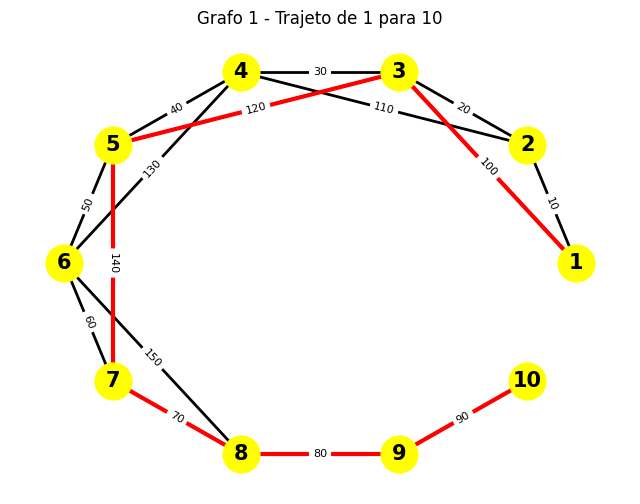


Trajeto de 2 para 9:
Caminho: [2, 4, 6, 8, 9]
Peso máximo: 80



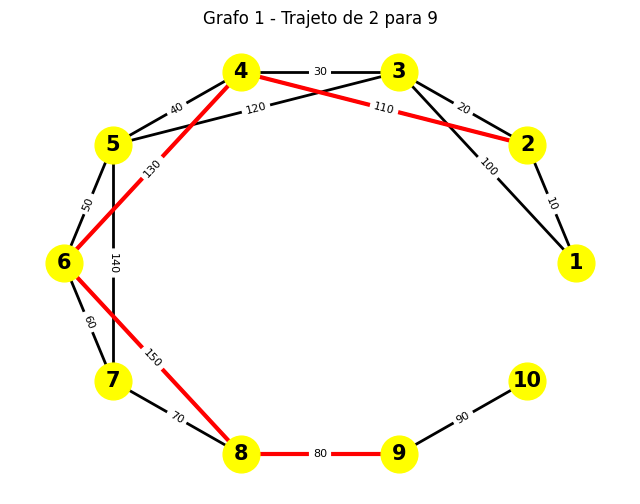


Trajeto de 3 para 8:
Caminho: [3, 5, 7, 8]
Peso máximo: 70



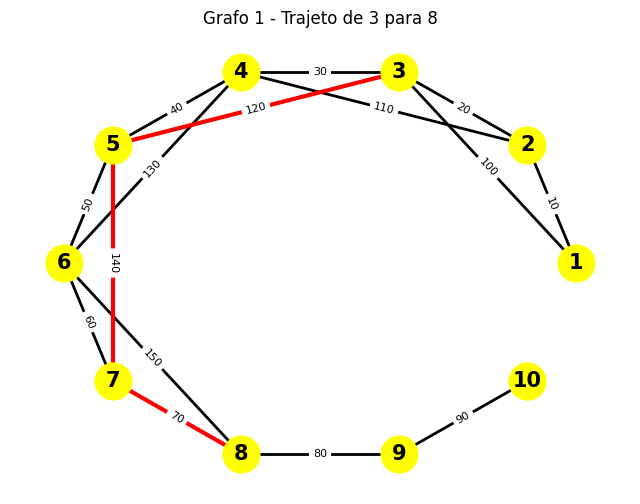


Trajeto de 4 para 7:
Caminho: [4, 6, 8, 7]
Peso máximo: 70



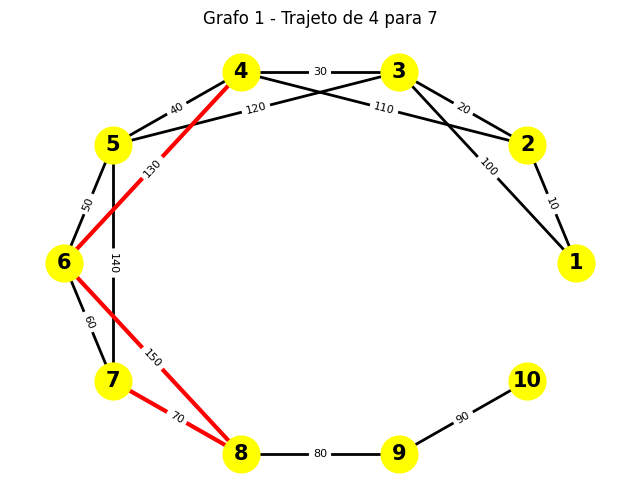


Trajeto de 5 para 6:
Caminho: [5, 7, 8, 6]
Peso máximo: 70



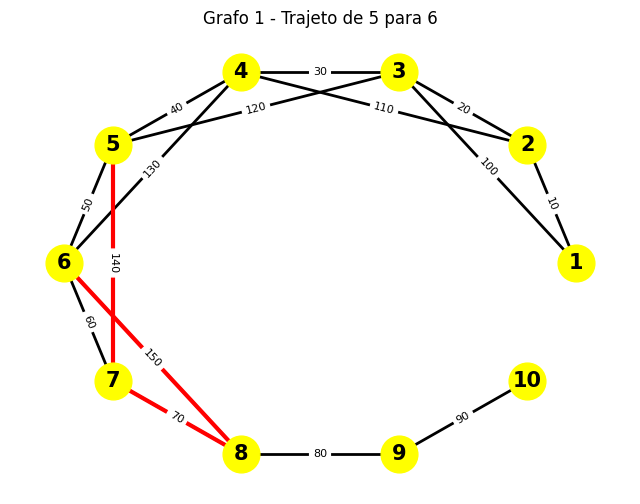


Output: 
70
80
70
70
70


In [107]:
# Passo 1: Separar os grafos
grafos = processar_matriz(matriz)

# Passo 2: Escolher o algoritmo a ser utilizado
print("Escolha o algoritmo a ser utilizado:\n")
print("1. Djikstra")
print("2. Djikstra Modificado")
print("3. Kruskal\n")
escolha = input()
if escolha == "1":
  processar_grafo = processar_grafo_djikstra
  alg = 'Djikstra'
elif escolha == "2":
  processar_grafo = processar_grafo_cmp
  alg = 'Djikstra Modificado'
elif escolha == "3":
  processar_grafo = processar_grafo_kruskal
  alg = 'Kruskal'
else:
  print("Opção inválida. Usando Djikstra Modificado por padrão.")
  processar_grafo = processar_grafo_cmp
  alg = 'Djikstra Modificado'

# Passo 3: Processar cada grafo e calcular os caminhos
for idx, grafo_info in enumerate(grafos, 1):
  print(f"\nResultados para o Grafo {idx} com algoritmo de {alg}:")
  resultados = processar_grafo(grafo_info, idx)

  print()
  print("Output: ")
  for resultado in resultados:
    print(resultado['peso'])